# MSCA 31009 Machine Learning & Predictive Analytics
## Final Project - Deep Learning Based Steam Store Game Recommender System
### Exploratory Data Analysis and Feature Engineering
Shijia Huang

-----

In [1]:
# Import basic libraries
import sys
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model

2023-05-18 13:40:36.473765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [4]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


## Exploratory Data Analysis

### Games

In [5]:
# read in the preprocessed data
games_df = pd.read_csv('preprocessed/games.csv')
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48756 entries, 0 to 48755
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          48756 non-null  int64  
 1   title           48756 non-null  object 
 2   date_release    48756 non-null  object 
 3   win             48756 non-null  int64  
 4   mac             48756 non-null  int64  
 5   linux           48756 non-null  int64  
 6   rating          48756 non-null  int64  
 7   positive_ratio  48756 non-null  int64  
 8   user_reviews    48756 non-null  int64  
 9   price_final     48756 non-null  float64
 10  price_original  48756 non-null  float64
 11  discount        48756 non-null  float64
 12  steam_deck      48756 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 4.8+ MB


In [6]:
games_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,1,0,0,3,92,37039,19.99,19.99,0.0,1
1,13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,3,84,2199,9.99,9.99,0.0,1
2,22364,BRINK: Agents of Change,2011-08-03,1,0,0,2,85,21,2.99,2.99,0.0,1
3,113020,Monaco: What's Yours Is Mine,2013-04-24,1,1,1,3,92,3722,14.99,14.99,0.0,1
4,226560,Escape Dead Island,2014-11-18,1,0,0,0,61,873,14.99,14.99,0.0,1


In [7]:
# phrasing the date column
games_df['date_release'] = pd.to_datetime(games_df['date_release'], format='%Y-%m-%d')

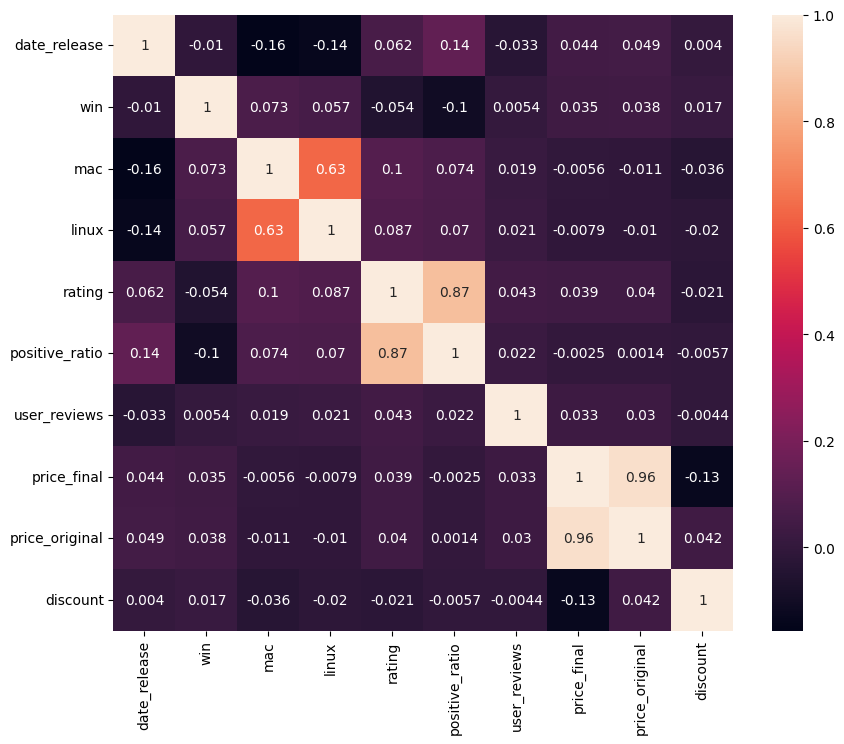

In [8]:
# plot correlation between numerical columns
plt.figure(figsize=(10, 8))
cols = ['date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount']
sns.heatmap(games_df[cols].corr(), annot=True)
plt.show()

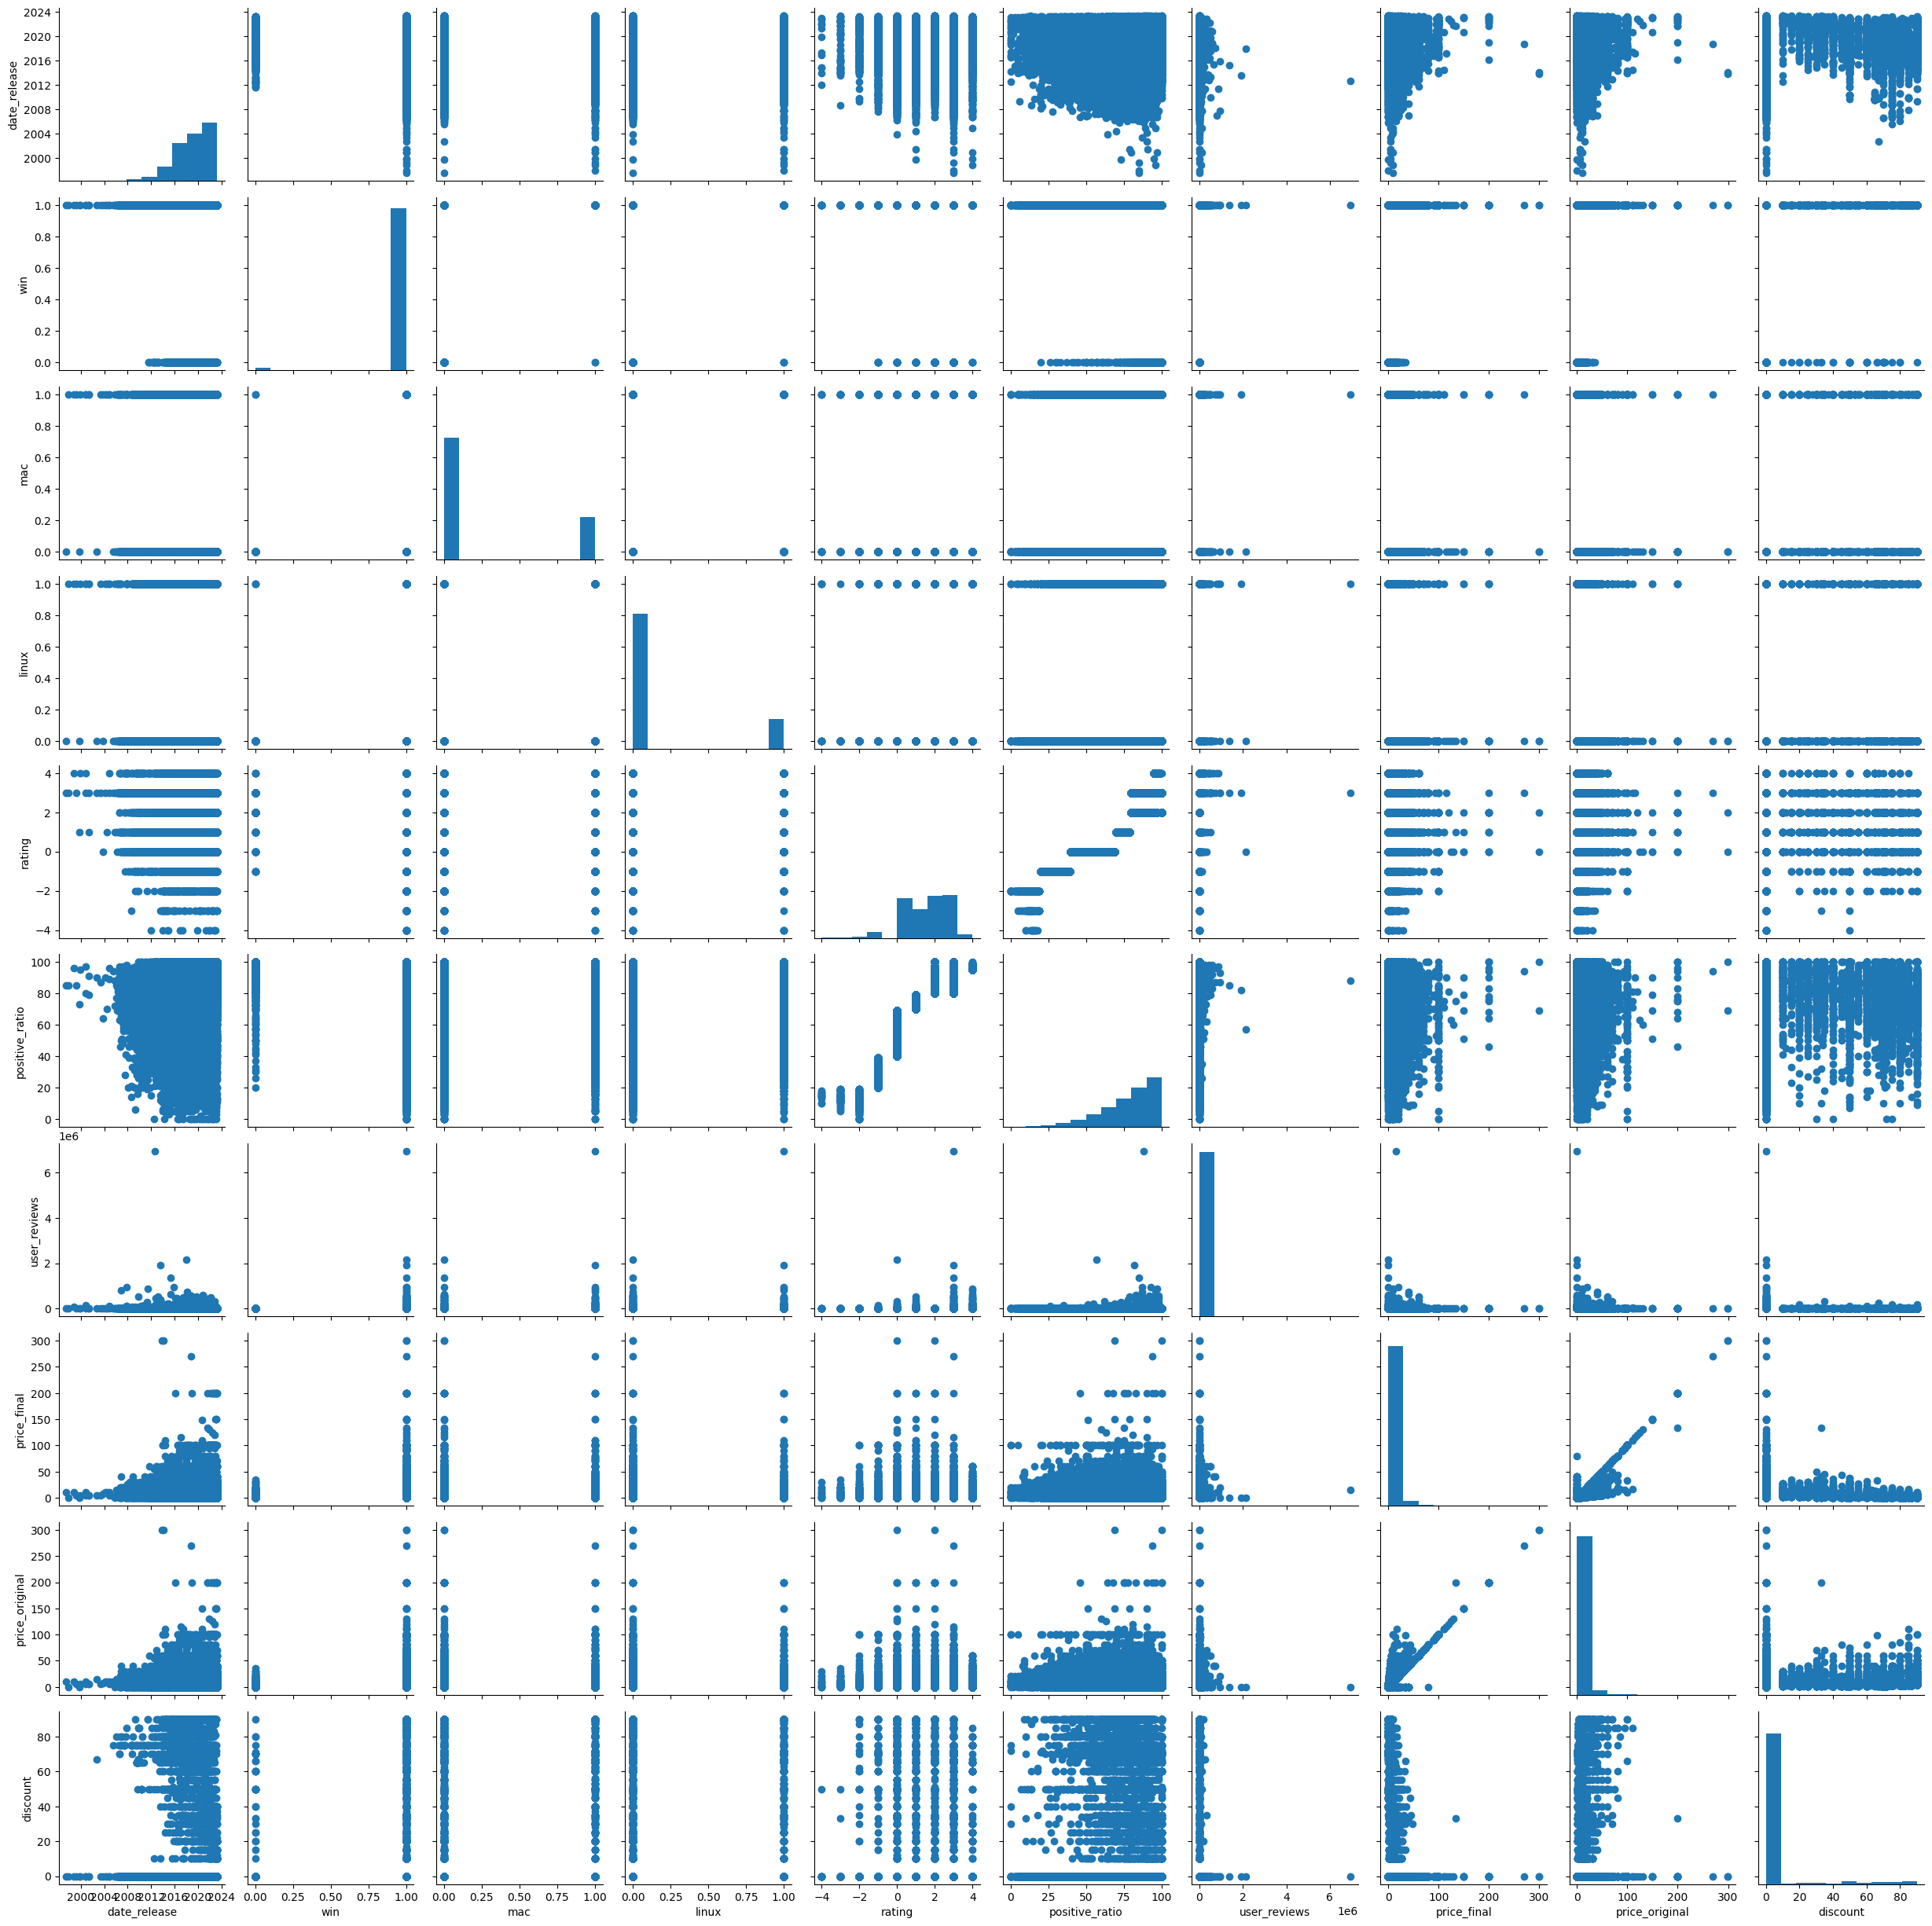

In [9]:
# make pairplot for numerical columns where diagonal is a histogram and other plots are scatter plots

ax = sns.PairGrid(games_df[cols], vars=cols)
ax = ax.map_offdiag(plt.scatter)
ax = ax.map_diag(plt.hist)

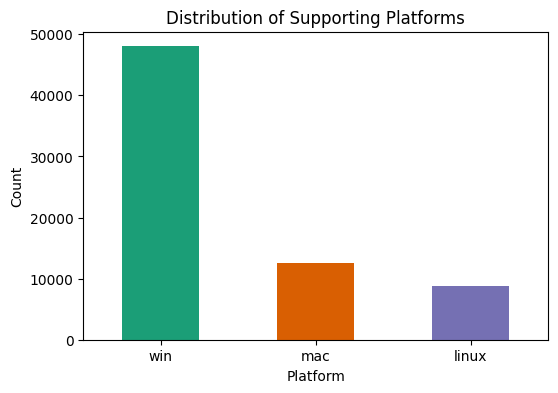

In [10]:
# plot supporting platforms: win, mac, linux using bar plot

# Calculate the count of each platform combination
subset_df = games_df[['win', 'mac', 'linux']]
platform_counts = subset_df.sum()

# Plot the bar plot
plt.figure(figsize=(6, 4))
platform_counts.plot(kind='bar', stacked=True, color=['#1b9e77', '#d95f02', '#7570b3'])
plt.title('Distribution of Supporting Platforms')
plt.xlabel('Platform')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()


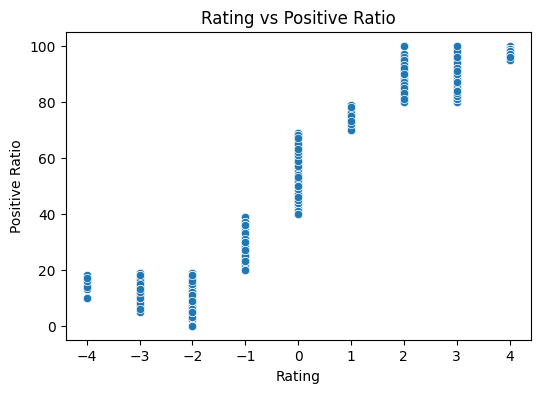

In [11]:
# rating vs positive_ratio
plt.figure(figsize=(6, 4))
sns.scatterplot(data=games_df, x='rating', y='positive_ratio')
plt.title('Rating vs Positive Ratio')
plt.xlabel('Rating')
plt.ylabel('Positive Ratio')
plt.show()

### Users

In [12]:
# read in the preprocessed data
users_df = pd.read_csv('preprocessed/users.csv')
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791175 entries, 0 to 6791174
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 155.4 MB


In [13]:
users_df.head()

,user_id,products,reviews
0,6654146,156,1
1,4191643,329,4
2,2261155,176,2
3,2437528,98,2
4,2700117,144,3


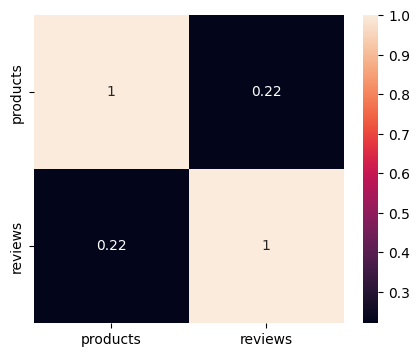

In [14]:
# plot correlation between numerical columns
plt.figure(figsize=(5, 4))
cols = ['products', 'reviews']
sns.heatmap(users_df[cols].corr(), annot=True)
plt.show()

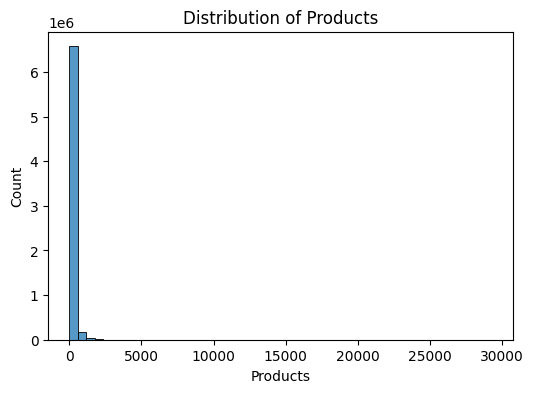

In [15]:
# plot distribution of products
plt.figure(figsize=(6, 4))
sns.histplot(data=users_df, x='products', bins=50)
plt.title('Distribution of Products')
plt.xlabel('Products')
plt.ylabel('Count')
plt.show()

### Reviews

In [16]:
# read in the preprocessed data
reviews_df = pd.read_csv('preprocessed/reviews.csv')
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13207260 entries, 0 to 13207259
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  int64  
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 806.1+ MB


In [17]:
reviews_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,1,36.3,23221,0
1,304390,4,0,2017-02-17,0,11.5,1283,1
2,1085660,2,0,2019-11-17,1,336.5,105979,2
3,703080,0,0,2022-09-23,1,27.4,108133,3
4,526870,0,0,2021-01-10,1,7.9,10612,4


In [18]:
# phrasing the date column
reviews_df['date'] = pd.to_datetime(reviews_df['date'], format='%Y-%m-%d')

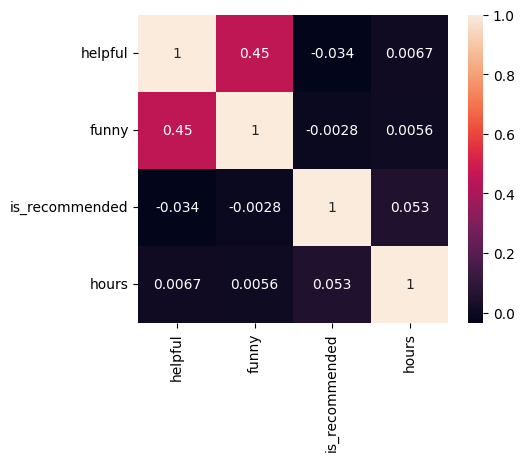

In [19]:
# plot correlation between numerical columns
plt.figure(figsize=(5, 4))
cols = ['helpful', 'funny', 'is_recommended', 'hours']
sns.heatmap(reviews_df[cols].corr(), annot=True)
plt.show()

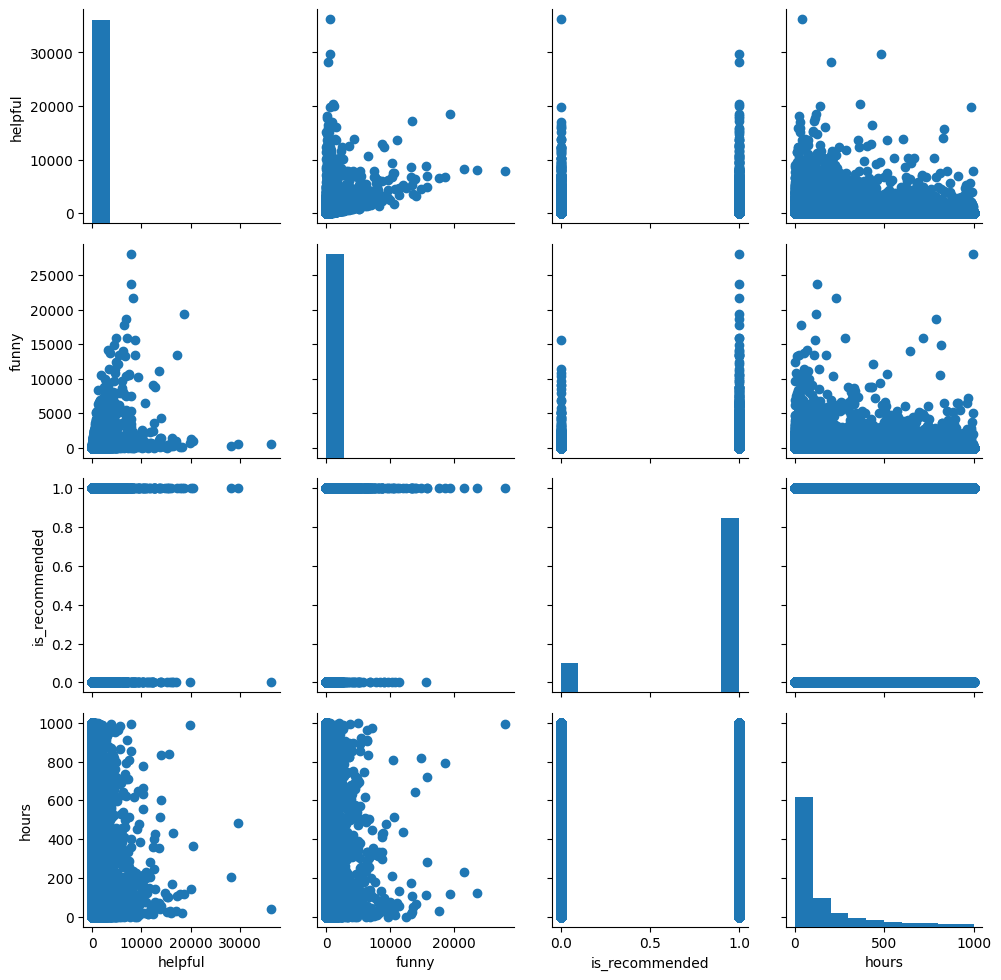

In [20]:
# make pairplot for numerical columns where diagonal is a histogram and other plots are scatter plots

ax = sns.PairGrid(reviews_df[cols], vars=cols)
ax = ax.map_offdiag(plt.scatter)
ax = ax.map_diag(plt.hist)

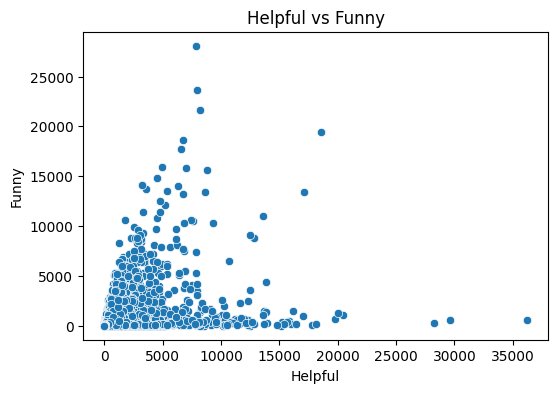

In [21]:
# helpful vs funny
plt.figure(figsize=(6, 4))
sns.scatterplot(data=reviews_df, x='helpful', y='funny')
plt.title('Helpful vs Funny')
plt.xlabel('Helpful')
plt.ylabel('Funny')
plt.show()

In [22]:
# helpful value counts
reviews_df['helpful'].value_counts()

helpful
0        10558324
2         1100221
3          448665
4          232067
5          142804
           ...   
2239            1
6826            1
1813            1
2523            1
10547           1
Name: count, Length: 2954, dtype: int64

In [23]:
# funny value counts
reviews_df['funny'].value_counts()

funny
0       12506621
2         279468
3         113013
4          60304
5          36863
          ...   
915            1
1358           1
2106           1
2575           1
2626           1
Name: count, Length: 2168, dtype: int64

### User Reviews

In [24]:
# read in preprocessed data
users_reviews_df = pd.read_csv('preprocessed/users_reviews.csv')
users_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13207260 entries, 0 to 13207259
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   products        int64  
 2   reviews         int64  
 3   app_id          int64  
 4   helpful         int64  
 5   funny           int64  
 6   date            object 
 7   is_recommended  int64  
 8   hours           float64
 9   review_id       int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 1007.6+ MB


In [25]:
users_reviews_df.head()

,user_id,products,reviews,app_id,helpful,funny,date,is_recommended,hours,review_id
0,6654146,156,1,730,0,0,2020-09-13,1,515.9,389270
1,4191643,329,4,1259420,5,0,2021-05-18,1,78.9,3220984
2,4191643,329,4,271590,0,0,2022-04-11,1,397.3,3273691
3,4191643,329,4,1029690,0,0,2022-11-26,1,67.6,8177218
4,4191643,329,4,1517290,12,2,2021-11-23,0,1.2,12305209


In [26]:
# phrasing the date column
users_reviews_df['date'] = pd.to_datetime(users_reviews_df['date'], format='%Y-%m-%d')

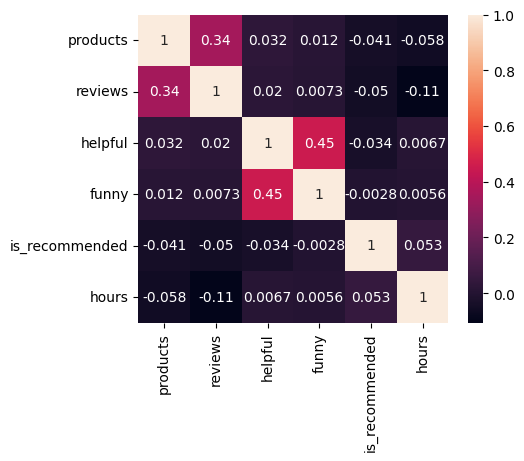

In [27]:
# plot correlation between numerical columns
plt.figure(figsize=(5, 4))
cols = ['products', 'reviews', 'helpful', 'funny', 'is_recommended', 'hours']
sns.heatmap(users_reviews_df[cols].corr(), annot=True)
plt.show()

## Feature Engineering